In [1]:
import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt

pathData     = '/Users/benjamin/DVPT/EEG/Data/AllSubjects_events_collision/'
pathData     = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/AllSubjects_events_collision/'
eventFiles   = glob.glob(pathData+"*_event*")
noEventFiles = glob.glob(pathData+"*_noevent*")

nEvent       = len (eventFiles)
nNoEvent     = len (noEventFiles)
nSample      = nEvent + nNoEvent
nChannels    = 59
nTimeStep    = 320

In [2]:
signalEvent   = np.zeros ( (nEvent  , nChannels, nTimeStep), dtype=float)
signalNoEvent = np.zeros ( (nNoEvent, nChannels, nTimeStep), dtype=float)

for i in range (nEvent):
    signalEvent[i]   = np.load (eventFiles  [i])[:,-nTimeStep::]
for i in range (nNoEvent):
    signalNoEvent[i] = np.load (noEventFiles[i])[:,-nTimeStep::]
       
signals  = np.concatenate((signalEvent, signalNoEvent))
mu       = np.mean (signals, axis=0)
signalsC = signals - mu

mu1  = np.mean (signalEvent  , axis=0)
mu2  = np.mean (signalNoEvent, axis=0)

* Creation du maillage Saptio-temporel

In [3]:
file_name ='/Users/benjamin/DVPT/EEG/Data/VPja.mat'
file_name ='/Users/obando_c/Documents/Neuro/EmergencyBraking/data/raw/VPja.mat'
with h5py.File(file_name, 'r') as f:
    mnt = f.get('mnt')
    pos3d_allChannels = np.array(mnt.get('pos_3d')) 

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

spatiotemp_mesh = []
for p in pos3d_eegChannels[:nChannels]: 
    xi, yi, zi = tuple(p)
    for ti in range(nTimeStep):
        spatiotemp_mesh.append([xi, yi, zi, ti])

* KL decomposition sur tous les Signaux 

In [6]:
import openturns as ot
dim_ch_in  = 1 
dim_ch_out = 1 
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) 
for k in range(process_sample.getSize()):
    field.setValues(signalsC[k].reshape(-1,1))
    process_sample[k] = field

s    = 0.0 
w_v  = np.ones(nChannels*nTimeStep) 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) 
algo.run()

fPCA     = algo.getResult()

* Controle de la qualité de la décomposition

In [7]:
vp       = fPCA.getEigenValues()
Phi      = fPCA.getModes()
Xi       = np.array(fPCA.project(process_sample))
XiLambda = Xi * ot.Point([np.sqrt(x) for x in vp])
T        = np.array([t for t in spatiotemp_mesh])
V_app    = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) 

Résidu Max de la norme:             5.300809477177109e-11
Ratio Valeur Propre 1/50:           0.0013730560066998743
Pourcentage de variance au mode 50: 0.9441231924741181


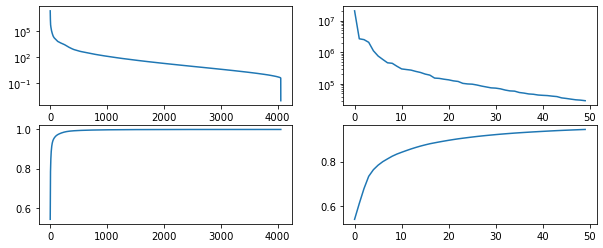

In [9]:
RandIdx = np.random.randint (0, process_sample.getSize()-1, 25 ).tolist()
Residu  = np.array ([V_app.getMarginal(k)(T) for k in RandIdx])
Residu -= np.array ([process_sample[k]for k in RandIdx])

pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(2,2, figsize=(10,4))

ax[0,0].semilogy(vp)  ; ax[0,1].semilogy(vp[0:50])
ax[1,0].plot    (pVar); ax[1,1].plot    (pVar[0:50])
print ('Résidu Max de la norme:            ', np.max(np.linalg.norm(Residu, axis =1)))
print ('Ratio Valeur Propre 1/50:          ', vp[50]/vp[0])
print ('Pourcentage de variance au mode 50:', pVar[49])

* Analyse par cluster (Event / NoEvent)

In [10]:
XiEvent   = Xi[0:len(eventFiles)]
XiNoEvent = Xi[len(eventFiles):nSample-1]



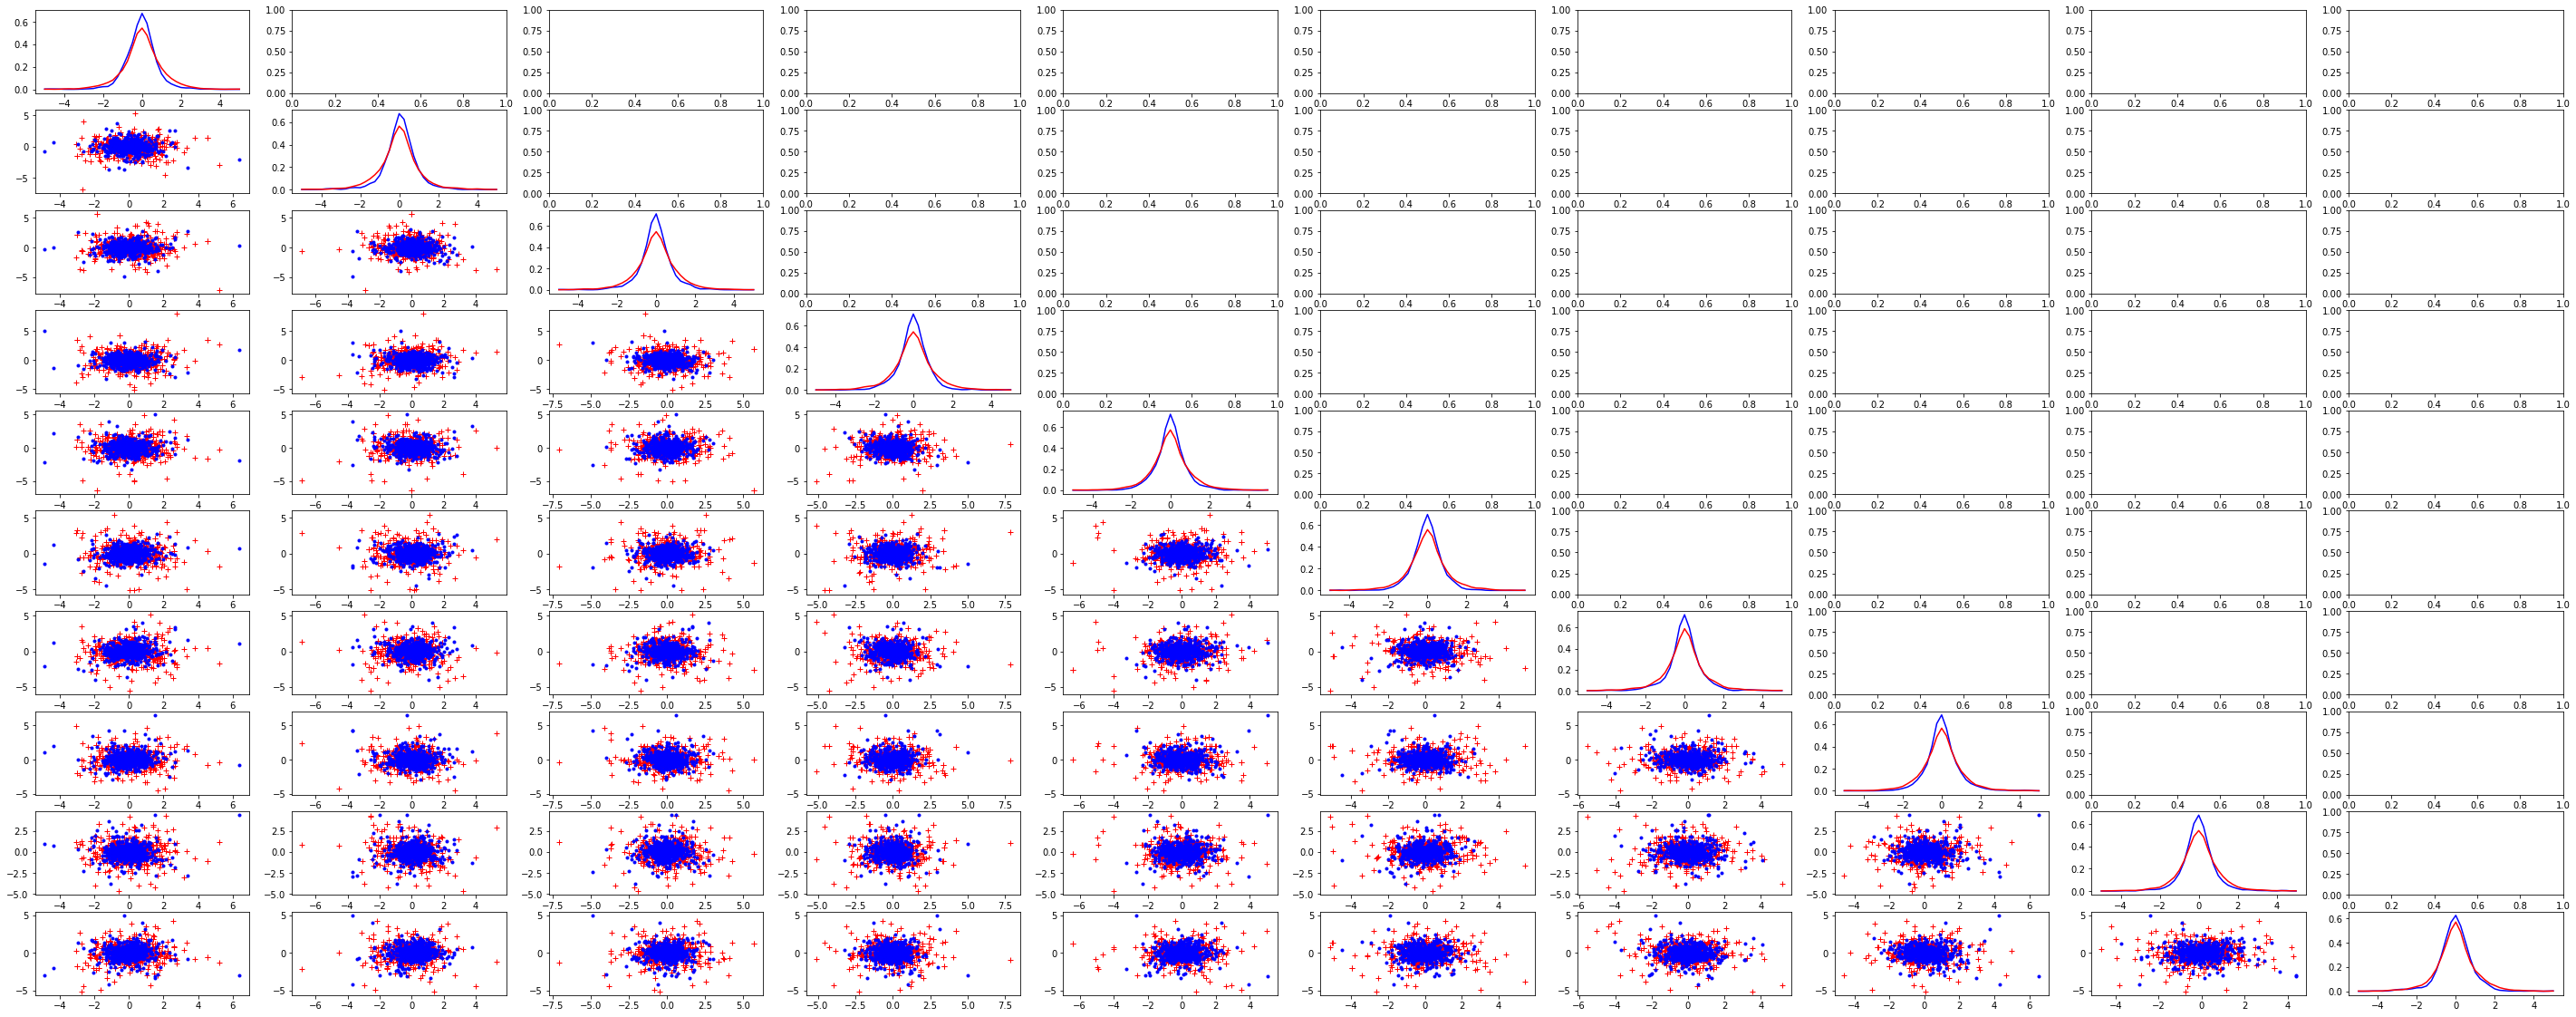

In [11]:
from scipy.stats.kde import gaussian_kde

minMode = 4000
nbModes = 10

marginalEvent    = [gaussian_kde(XiEvent  [:,k]) for k in range (minMode, minMode+nbModes)]
marginalNoEvent  = [gaussian_kde(XiNoEvent[:,k]) for k in range (minMode, minMode+nbModes)]

fig, ax = plt.subplots(nbModes,nbModes, figsize=(50,20))
x       = np.linspace(-5, 5.0, 41)

for k in range (0, nbModes):
    ax[k,k].plot (x, [marginalEvent  [k](i) for i in x], "b")
    ax[k,k].plot (x, [marginalNoEvent[k](i) for i in x], "r")

RandIdx = np.random.randint (0, len(XiNoEvent)-1, len(XiEvent)).tolist()
XiNoEvt = np.array([XiNoEvent[k,:] for k in RandIdx])
for k in range (minMode,minMode+nbModes):
    ik = k - minMode
    for j in range (minMode, k):
        ij = j - minMode
        ax[ik,ij].plot (XiNoEvt[:,j], XiNoEvt[:,k],'r+')
        ax[ik,ij].plot (XiEvent[:,j], XiEvent[:,k],'b.')
